**Imports**

In [1]:
import torch
from torch import nn

import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np 
import random 
import timeit
from tqdm.auto import tqdm

**Hyperparameters**

In [2]:
random_seed = 42

batch_size = 512

num_classes = 46
patch_size = 4
img_size = 32
in_channels = 1
num_heads = 8
dropout = 0.001
hidden_dim = 1024
adam_weight_decay = 0
adam_betas = (0.9, 0.999)
activation = "gelu"
num_encoders = 4
embed_dim = (patch_size ** 2) * in_channels # 16
num_patches = (img_size // patch_size) ** 2 # 64

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.mps.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Device: {device}!")

Device: mps!


In [3]:
from patch_embedding import PatchEmbedding

model = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels).to(device)

x = torch.randn(512, 1, img_size, img_size).to(device)

print(model(x).shape)

# expected: torch.Size([512, num_patches + 1, embed_dim]) 

torch.Size([512, 65, 16])


In [4]:
from vision_transformer import VisionTransformerKAN
    
model = VisionTransformerKAN(num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels).to(device)

x = torch.randn(512, 1, img_size, img_size).to(device)

print(model(x).shape)

# expected: torch.Size([512, num_classes])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([512, 46])


**Loading Data**

In [5]:
train_dir = "data/train"
test_dir = "data/test"

In [6]:
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(15), # Random Rotation by 15 degs
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    transforms.Normalize([0.5], [0.5])
])
test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [7]:
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=train_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, transform = test_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 78200
    Root location: data/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 13800
    Root location: data/test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [8]:
class2idx = train_data.class_to_idx
idx2class = {k:v for v, k in class2idx.items()}

character_19_dha


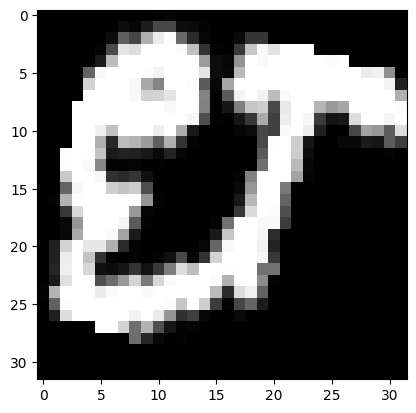

In [9]:
rand_int = np.random.randint(0, high = len(train_data))

print(idx2class[train_data[rand_int][1]])
_ = plt.imshow(train_data[rand_int][0].permute(1, 2, 0), cmap = "gray")

In [10]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=batch_size, 
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=batch_size,  
                             shuffle=False) 

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x4729c5100>,
 <torch.utils.data.dataloader.DataLoader at 0x4729c9520>)

**Training**

In [11]:
learning_rate = 5e-3
num_epochs = 50

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), betas = adam_betas, lr = learning_rate, weight_decay = adam_weight_decay)

scheduler = optim.lr_scheduler.StepLR(optimizer = optimizer, step_size = 5, gamma = 0.95)

start = timeit.default_timer()

history = {"train_loss": [],
          "val_loss": [],
          "train_acc": [],
          "val_acc": []}

for epoch in tqdm(range(num_epochs), position = 0, leave = True):
    model.train()
    
    train_labels = []
    train_preds = []
    
    train_running_loss = 0
    
    for idx, img_label in enumerate(tqdm(train_dataloader, position = 0, leave = False)):
        img = img_label[0].float().to(device)
        label = img_label[1].type(torch.uint8).to(device)
        
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim = 1)
        
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        
    train_loss = train_running_loss / (idx + 1)
    scheduler.step(loss)
    

    model.eval()

    val_labels = []
    val_preds = []
    val_running_loss = 0

    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(test_dataloader, position = 0, leave = False)):
            img = img_label[0].float().to(device)
            label = img_label[1].type(torch.uint8).to(device)

            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim = 1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)

            val_running_loss += loss.item()

        val_loss = val_running_loss / (idx + 1)

        train_acc = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)
        val_acc = sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)

        print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}", end="\r")

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
            
        
stop = timeit.default_timer()
print()
print(f"Training Time: {stop-start:.2f}s")
        

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Training Time: 4804.64s


In [12]:
torch.save(model.state_dict(), f"models/kan-hindi-character-recognition-{num_epochs}epochs")

In [13]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, f"models/kan-hindi-character-recognition-{num_epochs}epochs-to-train.pt")

Code to load checkpoint for further training
```
checkpoint = torch.load("models/hindi-character-recognition-100epochs-to-train.pt")

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
```

Axes(0.125,0.53;0.775x0.35)


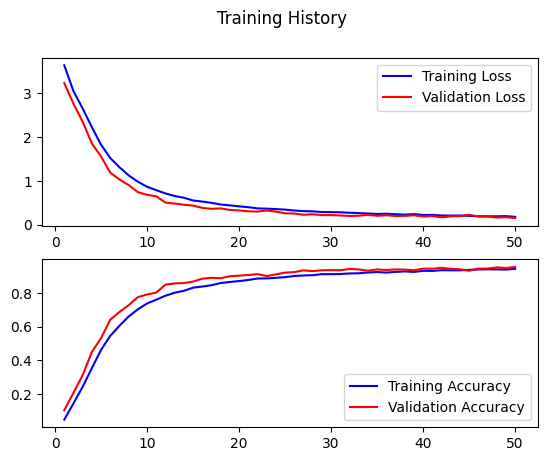

In [16]:
fig, ax = plt.subplots(2)
history = pd.DataFrame(history)

fig.suptitle('Training History')
print(ax[0])

ax[0].plot(range(1, len(history)+1), history["train_loss"], color = 'b', label = "Training Loss")
ax[0].plot(range(1, len(history)+1), history["val_loss"], color = 'r', label = "Validation Loss")

ax[1].plot(range(1, len(history)+1), history["train_acc"], color = 'b', label = "Training Accuracy")
ax[1].plot(range(1, len(history)+1), history["val_acc"], color = 'r', label = "Validation Accuracy")

ax[0].legend()
ax[1].legend()
plt.show()

In [17]:
history.to_csv("history-kan-100.csv")

### Resume from Checkpoint

In [48]:
checkpoint = torch.load("models/kan-hindi-character-recognition-70epochs-to-train.pt")

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
prev_epoch = checkpoint['epoch'] + 1
loss = checkpoint['loss']

In [60]:
num_epochs = 10

criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer = optimizer, step_size = 1, gamma = 0.9)

start = timeit.default_timer()

history = {"train_loss": [],
          "val_loss": [],
          "train_acc": [],
          "val_acc": []}

for epoch in tqdm(range(num_epochs), position = 0, leave = True):
    model.train()
    
    train_labels = []
    train_preds = []
    
    train_running_loss = 0
    
    for idx, img_label in enumerate(tqdm(train_dataloader, position = 0, leave = False)):
        img = img_label[0].float().to(device)
        label = img_label[1].type(torch.uint8).to(device)
        
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim = 1)
        
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        
    train_loss = train_running_loss / (idx + 1)
    scheduler.step(loss)
    

    model.eval()

    val_labels = []
    val_preds = []
    val_running_loss = 0

    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(test_dataloader, position = 0, leave = False)):
            img = img_label[0].float().to(device)
            label = img_label[1].type(torch.uint8).to(device)

            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim = 1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)

            val_running_loss += loss.item()

        val_loss = val_running_loss / (idx + 1)

        train_acc = sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels)
        val_acc = sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels)

        print(f"Epoch {prev_epoch + epoch + 1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}", end="\r")

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
            
        
stop = timeit.default_timer()
print()
print(f"Training Time: {stop-start:.2f}s")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch 80: Train Loss: 0.1039 | Val Loss: 0.1147 | Train Acc: 0.9649 | Val Acc: 0.9670
Training Time: 1047.24s


In [61]:
torch.save({
            'epoch': prev_epoch+epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, f"models/kan-hindi-character-recognition-{prev_epoch+num_epochs}epochs-to-train.pt")

Axes(0.125,0.53;0.775x0.35)


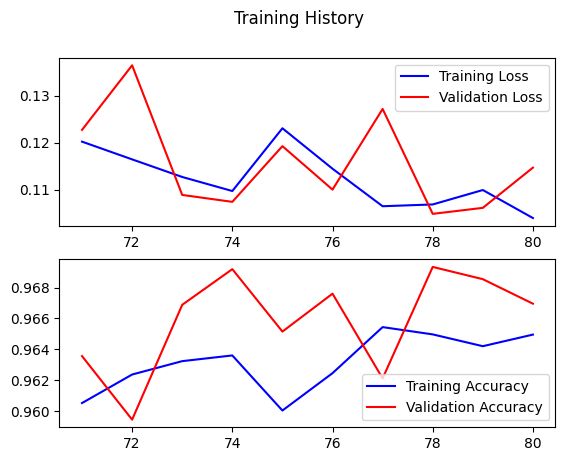

In [62]:
fig, ax = plt.subplots(2)
history = pd.DataFrame(history)

fig.suptitle('Training History')
print(ax[0])

ax[0].plot(range(prev_epoch+1, prev_epoch+len(history)+1), history["train_loss"], color = 'b', label = "Training Loss")
ax[0].plot(range(prev_epoch+1, prev_epoch+len(history)+1), history["val_loss"], color = 'r', label = "Validation Loss")

ax[1].plot(range(prev_epoch+1, prev_epoch+len(history)+1), history["train_acc"], color = 'b', label = "Training Accuracy")
ax[1].plot(range(prev_epoch+1, prev_epoch+len(history)+1), history["val_acc"], color = 'r', label = "Validation Accuracy")

ax[0].legend()
ax[1].legend()
plt.show()

Axes(0.125,0.53;0.775x0.35)


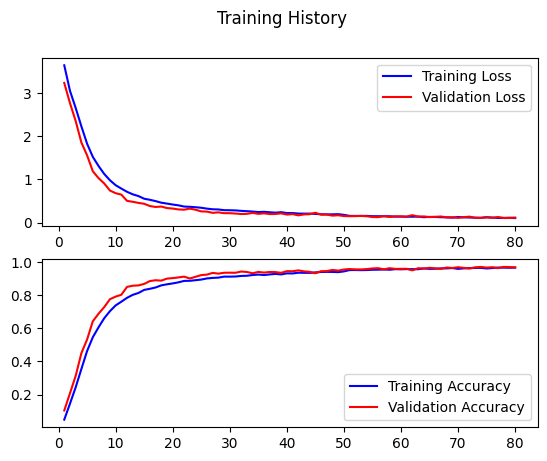

In [63]:
fig, ax = plt.subplots(2)
history = pd.DataFrame(history)

history = pd.concat([pd.read_csv("history-kan-70.csv"), history]).reset_index(drop=True)

fig.suptitle('Training History')
print(ax[0])

ax[0].plot(range(1, len(history)+1), history["train_loss"], color = 'b', label = "Training Loss")
ax[0].plot(range(1, len(history)+1), history["val_loss"], color = 'r', label = "Validation Loss")

ax[1].plot(range(1, len(history)+1), history["train_acc"], color = 'b', label = "Training Accuracy")
ax[1].plot(range(1, len(history)+1), history["val_acc"], color = 'r', label = "Validation Accuracy")

ax[0].legend()
ax[1].legend()
plt.show()

In [64]:
history.to_csv(f"history-kan-{prev_epoch+epoch}.csv")